In [72]:
# All dependencies
import sys
import requests
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

from os import path
from time import time
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D as plt3

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler as SS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.inspection import permutation_importance as perm_imp
from sklearn.model_selection import train_test_split as tts, cross_validate, GridSearchCV as GSCV, RandomizedSearchCV as RSCV

# important global constants
global default_data_percentage
default_data_percentage = 1

## A Brief Machine Learning Analysis on Car Accidents in the United Kingdom

We are Michael Coffey and Hayden Corbin, and for our 2023 CS 345 Term Project, we have decided to analyze data relating to car accidents in the United Kingdom from 2005 to 2014.  We downloaded our data from the website www.kaggle.com/code/sohamsave/accident-data-analysis, which consisted of three `.csv` files with a very large amount of features and over three million records.  We aimed to solve three questions, two of which revolve around the use of classifiers, and one around regression.  To answer these questions, we used multiple classifiers and regressors to see how they perform.

Our project provided unique challenges in that our dataset was very large.  In fact, all three of the downloaded `.csv` files amounted to approximately 3 GB!  This would cause the execution time of our models to be unreasonably wrong, so our first real challenge was to figure out a way to use a subset of our data.  Another issue was that the features which we intended to use as classification labels did not have equal representation, so we had to resolve this issue while getting our subset ready to be inputted into our models.  Once we had a much smaller subset of data and equal representation in our labels for our classification problems, we could run the models without issue.

Our primary goal in answering our three questions is to determine which features contributed the most to our classifiers and regressors decisions with regard to the hyperplane and regression line respectively.  We could easily figure this out by looking up the features with the hightest weight values, which imply their importance to the models.  We did do this, but we also decided to go a step further and run our models again using just the features that yielded the highest weight values.  In this way, we could truly determine which features contributed the most to the decisions of our classifiers and regressors.

Here are our results:

**Commonly Used Methods**

The methods below are commonly used when running a variety of classification and regression models.

**Culling the Accidents Data**

All across the dataset, we discovered that there were some columns with an unequal amount of labels.  For example, there were very few entires with an `Accident_Severity` of 1 (meaning that it was likely fatal) compared to 3 (meaning that the accident was relatively mild).  We tried using the data as it was at first, but this led to a high accuracy on training sets with mostly mild accidents.  This uneven distribution could prove disasterous when running classification models, so we created a method, `cull_data` to return a smaller subset of the data with a relatively equal representation of the labels we tested our classifiers on. Even if we yielded a lower accuracy in both the training and testing dataset, we did ensure that each unique label value got relatively equal representation.

**Custom Cross Validation**

We created a method for cross validation, `custom_cv`, to run cross validation on every classifier we passed in.  Later, we added functionality that also allowed the method to perform cross validation and report the results for regressors.  Otherwise, our methodlogy for cross validation is similar to that f what `sklearn` provides.

In [73]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

def get_mean_absolute_error(y, y_pred):
    return np.mean(np.absolute(np.asarray(y) - np.asarray(y_pred)))

def cull_data(frame_key, features, percent_of_even_data_to_use=default_data_percentage,
              exclude_labels=None):
    copied_dataset = data_frames[frame_key][features].dropna().values.copy()
    if exclude_labels is not None:
        for label in exclude_labels:
            copied_dataset = copied_dataset[copied_dataset[:, -1] != label]

    np.random.shuffle(copied_dataset)
    
    unique_labels, unique_label_counts = np.unique(copied_dataset[:, -1], return_counts=True)
    returning_dataset = copied_dataset[copied_dataset[:, -1] == unique_labels[0]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]
    for l in range(1, len(unique_labels)):
        returning_dataset = np.vstack((returning_dataset, copied_dataset[copied_dataset[:, -1] == unique_labels[l]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]))
    
    np.random.shuffle(returning_dataset)
    return returning_dataset

def mult_list(val_list):
    product = len(val_list[0])

    for val in val_list:
        product *= len(val_list)

    return product

def count_iters(params):
    param_lens = [len(val) for _, val in params.items()]
    return sum(param_lens) + mult_list(param_lens)
    

def custom_cv(estimators, X, y, params_list, scoring = 'accuracy', test_size=0.3, seed=42, timed=True, verbose=False, random_search=False):
    if timed: start_time = time()

    ret_dict = {}
    X_train, X_test, y_train, y_test = tts(X, y, test_size=test_size, random_state=seed)

    if len(estimators) != len(params_list):
        print("The number of estimators and corresponding parameters does not match")
        return
        
    for a in range(len(estimators)):
        estimator_name = estimators[a].__class__.__name__
        if timed: individual_time = time()

        if random_search:
            search_tag = "rscv"
            search_cv = RSCV(estimators[a], params_list[a], scoring = scoring, verbose=2 if verbose else 0)
        else:
            search_tag = "gscv"
            search_cv = GSCV(estimators[a], params_list[a], scoring = scoring, verbose=2 if verbose else 0)
        
        pipe = Pipeline([("scaler", SS()), (search_tag, search_cv)])
        pipe.fit(X_train, y_train)
        
        if scoring == 'neg_mean_absolute_error':
            ret_dict[estimator_name] = {
                "best_mae": get_mean_absolute_error(y_test, pipe.predict(X_test)),
                "best_estimator": pipe.named_steps[search_tag].best_estimator_,
                "best_params": pipe.named_steps[search_tag].best_params_,
                "best_score": pipe.named_steps[search_tag].best_score_,
                "gs_results": pipe.named_steps[search_tag].cv_results_,
            }
        else:
            ret_dict[estimator_name] = {
                "best_accuracy": get_accuracy(y_test, pipe.predict(X_test)),
                "best_estimator": pipe.named_steps[search_tag].best_estimator_,
                "best_params": pipe.named_steps[search_tag].best_params_,
                "best_score": pipe.named_steps[search_tag].best_score_,
                "gs_results": pipe.named_steps[search_tag].cv_results_,
            }

        if estimator_name == "SVC":
            try:
                ret_dict[estimator_name]["feature_importances"] = pipe.named_steps[search_tag].best_estimator_.coef_ / pipe.named_steps["scaler"].scale_
            except AttributeError:  # Only valid for linear kernel
                importance = perm_imp(ret_dict[estimator_name]["best_estimator"], X_test, y_test, n_repeats=30, random_state=seed)
                ret_dict[estimator_name]["feature_importances"] = importance.importances_mean.argsort()
        if estimator_name == "RandomForestClassifier":
            ret_dict[estimator_name]["feature_importances"] = pipe.named_steps[search_tag].best_estimator_.feature_importances_

        if timed: ret_dict[estimator_name]["fit_time"] = time() - individual_time
        if verbose and timed: print(f"{estimator_name} fit time: {ret_dict[estimator_name]['fit_time']:.3f} seconds")

    if timed: ret_dict["total_time"] = time() - start_time
    if verbose and timed: print(f"Total Cross Validation fit time: {ret_dict['total_time'] / 60:.3f} minutes\n")

    return ret_dict

def print_cv_results(cust_cv_results, precision=3, problem_type = "classification"):
    for key, results_dict in cust_cv_results.items():
        if not isinstance(results_dict, dict) or key == "dataset":
            continue

        # print(f"Dict: {key}, Keys: {results_dict.keys()}")
        print(f"Showing results of Grid Search and Cross Validation for: {key}")
        print(f"\tBest Params: {results_dict['best_params']}")
        print(f"\tBest Score: {results_dict['best_score']:.{precision}f}")
        if problem_type == "regression":
            print(f"\tFinal {key} Mean Absolute Error: {results_dict['best_mae']:.{precision}f}")
        else:
            print(f"\tFinal {key} Accuracy: {results_dict['best_accuracy']:.{precision}f}%")
        try:
            print(f"\t{key} Fit Time: {results_dict['fit_time']:.{precision}f} seconds\n")
        except KeyError:
            print()

    try:
        print(f"Total time to fit all classifiers: {cust_cv_results['total_time'] / 60:.{precision}f} minutes")
    except KeyError:
        pass

**Downloading of the Data Files**

We used dropbox to store the CSV files and used their urls to load them into pandas Dataframes using our custom method `dataframe_from_csv`.
To save load time, if the method first checks if the datasets are already downloading before attempting to download from the dropbox.

In [74]:
# Download data files
def load_datasets(combined=False, include_only=None):
    urls = {
        "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
        "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
        "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
        "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
    }

    ret_frames = {}

    exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
    valid_datasets = list(urls.keys())[:-1]
    for file_name in valid_datasets:
        if include_only is not None:
            if file_name not in include_only and not combined: continue
                
        print(f"Loading {file_name}.csv")
        if path.exists(f"{file_name}.csv"):
            ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
            continue
        
        direct_url = urls[file_name].replace("&dl=0", "&dl=1")
        response = requests.get(direct_url)

        with open(f"{file_name}.csv", "wb") as f:
            f.write(response.content)
            print(f"Wrote {file_name}.csv")

        ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

    if combined:
        print("Creating combined table")
        ret_frames["combination"] = pd.concat([ret_frames[name] for name in valid_datasets], axis=1)
        ret_frames["combination"] = ret_frames["combination"].loc[:, ~ret_frames["combination"].columns.duplicated()]

    if include_only is not None:
        for key in list(ret_frames):
            if combined and key == "combination": continue
            if key not in include_only:
                print(f"**  Removing {key}")
                del ret_frames[key]

    return ret_frames

## Method
We approached testing each classifier for all classification problems by using Grid Search Cross Validation n on our culled dataset to obtain the best parameters for each classifier.

In [75]:
def gen_logspace(min, max, N, as_int=False):
    log_list = np.logspace(np.log10(min), np.log10(max), N)
    if not as_int: return log_list
    else: return np.round(log_list).astype(int)

def run_classifier_models(frame_key, features=None, percent_of_even_data_to_use=None,
                          exclude_labels=None, plot_ftrs=False, verbose=False):
    if percent_of_even_data_to_use is None:
        dataset = cull_data(frame_key, features=features, exclude_labels=exclude_labels)
    else:
        dataset = cull_data(
            frame_key,
            features=features,
            percent_of_even_data_to_use=percent_of_even_data_to_use,
            exclude_labels=exclude_labels
        )

    if verbose: print(f"Culled label counts:\n{np.unique(dataset[:, -1], return_counts=True)}")

    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    if plot_ftrs: plot_ftrs(X, y, dimensions=2)
    
    svc_params = {
        "kernel": ["linear", "rbf"],
        "C": gen_logspace(0.001, 10, 5),
        "gamma": gen_logspace(0.001, 10, 5),
    }
    rfc_params = {
        "n_estimators": gen_logspace(1, 1000, 5, as_int=True),
    }
    knn_params = {
        "n_neighbors": gen_logspace(1, 100, 8, as_int=True)
    }

    results = custom_cv([SVC(), RFC(), KNN()], X, y, params_list=[svc_params, rfc_params, knn_params], scoring = 'accuracy', verbose=verbose)
    results["dataset"] = {
        "frame_key": frame_key,
        "exclude_labels": exclude_labels,
        "X": X,
        "y": y,
    }
    if verbose: print_cv_results(results, precision=4)
    return results

def create_feature_pair_plot(accident_data, feature_names, labels, index_of_first_feature=0, index_of_second_feature=1):
    plt.scatter(accident_data[:, 0], accident_data[:, 1], c=labels, cmap="viridis", alpha=0.75)
    plt.xlabel(feature_names[index_of_first_feature])
    plt.ylabel(feature_names[index_of_second_feature])
    plt.show()

def print_label_counts(dataset):
    labels, counts = np.unique(dataset[:, -1], return_counts=True)
    for label, count in zip(labels, counts):
        print(f"Label: {label}, Count: {count}")

def collect_top_features(num_of_top_feature_to_return, feature_names, feature_weights):
    if num_of_top_feature_to_return >= len(feature_names):
        return
    
    top_feature_names = np.array([])
    top_feature_weights = np.array([])
    for f in range(0, num_of_top_feature_to_return):
        most_important_feature_index = feature_weights.argmax()
        top_feature_names = np.append(top_feature_names, feature_names[most_important_feature_index])
        top_feature_weights = np.append(top_feature_weights, feature_weights[most_important_feature_index])
        feature_names = np.delete(feature_names, most_important_feature_index)
        feature_weights = np.delete(feature_weights, most_important_feature_index)
    return top_feature_names, top_feature_weights


### First Question: Can the severity of an accident be predicted based on weather and road conditions?

Our first experiment involved training three different classifiers - SVM, Random Forest, and K Nearest Neighbors - on our dataset when using the features `Weather_Conditions`, `Road_Surface_Conditions`, `Special_Conditions_at_Site`, and`Carriageway_Hazards`.  `Accident_Severity` was the label that was being predicted, with 3 meaning that the accident was mild, 2 meaning that the accident was moderate, and 1 implying possible fatalities.

In [76]:
# Optimized Dataframe loading for low-memory systems
data_frames = load_datasets(combined=True, include_only=["accidents"])

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Creating combined table
**  Removing vehicles
**  Removing casualties


In [77]:
# Loads all of the features with the highest importance into a list, with the label being added at the end
def load_feature_audition_winners(all_features, indexes_of_winners):
    finalists = []
    for i in indexes_of_winners:
        finalists.append(all_features[i])
    finalists.append(all_features[-1])
    return finalists

In [78]:
# First Question: How does the weather impact the serverity of the accident?
feature_names = ["Weather_Conditions", "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
severity_results = run_classifier_models("accidents", feature_names, 0.05)

output = {
    "Accuracy %": [],
    "Estimator": [],
}

for estimator in severity_results.keys():
    if estimator == "total_time" or estimator == "dataset": continue
    output["Accuracy %"].append(severity_results[estimator]["best_accuracy"])
    output["Estimator"].append(estimator)

pd.DataFrame(output)

,Accuracy %,Estimator
0,89.405,SVC
1,89.303,RandomForestClassifier
2,87.322,KNeighborsClassifier


**Initial Results**

Using cross validation, we found that all three classifiers are able to obtain around an 88 to 91 percent accuracy in classifying the severity of an accident and road conditions.  The classifier yielding the greatest accuracy was generally interchangable between the SVM and Random Forest models, with the K Nearest Neighbors model consistently yielding the lowest accuracy.

We were unable to acquire the features that the K Nearest Neighbors classifier considered to be the most important.  But we did find that the Random Forest classifier often found the `Weather_Conditions` and `Road_Surface_Conditions` features to be the most useful features in deciding the severity of an accident.  The SVM classifier, on the other hand, found a combination of the `Road_Surface_Conditions`, `Special_Conditions_at_Site`, and `Carriageway_Hazards` features to be helpful in classifying the severity of a car accident.

We decided to investigate further on whether the beforementioned features were helpful by running the combinations of the most important features according to the Random Forest and SVM models separately.  We first did this with the feature combination that the Random Forest classifier considered the best.  We did the same thing with the best features according to SVM afterwards.

**Running Classification Models on the Features Considered the Most Important According to the Random Forest**

In [79]:
rfc_audition_best_feature_names = load_feature_audition_winners(feature_names, np.argsort(severity_results["RandomForestClassifier"]["feature_importances"])[-2:][::-1])
print("Best features with label", rfc_audition_best_feature_names[2], "according to the RFC classifier:", rfc_audition_best_feature_names[0], "and", rfc_audition_best_feature_names[1])

actual_best_rfc_severity_results = run_classifier_models("accidents", rfc_audition_best_feature_names, 0.05)

output = {
    "Accuracy %": [],
    "Estimator": [],
}

for estimator in actual_best_rfc_severity_results.keys():
    if estimator == "total_time" or estimator == "dataset": continue
    output["Accuracy %"].append(actual_best_rfc_severity_results[estimator]["best_accuracy"])
    output["Estimator"].append(estimator)

pd.DataFrame(output)

Best features with label Accident_Severity according to the RFC classifier: Weather_Conditions and Special_Conditions_at_Site


,Accuracy %,Estimator
0,82.200,SVC
1,82.173,RandomForestClassifier
2,82.224,KNeighborsClassifier


**Running Classification Models on the Features Considered the Most Important According to the Random Forest**

In [80]:
rfc_audition_best_feature_names = load_feature_audition_winners(feature_names, np.argsort(severity_results["RandomForestClassifier"]["feature_importances"])[-2:][::-1])
print("Best features with label", rfc_audition_best_feature_names[2], "according to the RFC classifier:", rfc_audition_best_feature_names[0], "and", rfc_audition_best_feature_names[1])

actual_best_rfc_severity_results = run_classifier_models("accidents", rfc_audition_best_feature_names, 0.05)

output = {
    "Accuracy %": [],
    "Estimator": [],
}

for estimator in actual_best_rfc_severity_results.keys():
    if estimator == "total_time" or estimator == "dataset": continue
    output["Accuracy %"].append(actual_best_rfc_severity_results[estimator]["best_accuracy"])
    output["Estimator"].append(estimator)

pd.DataFrame(output)

Best features with label Accident_Severity according to the RFC classifier: Weather_Conditions and Special_Conditions_at_Site


,Accuracy %,Estimator
0,81.018,SVC
1,81.331,RandomForestClassifier
2,85.722,KNeighborsClassifier


**Running Classification Models on the Features Considered the Most Important According to the SVM**

In [81]:
svm_audition_best_feature_names = load_feature_audition_winners(feature_names, np.argsort(severity_results["SVC"]["feature_importances"])[-2:][::-1])
print("Best features with label", svm_audition_best_feature_names[2], "according to the SVM classifier:", svm_audition_best_feature_names[0], "and", svm_audition_best_feature_names[1])
actual_best_svm_severity_results = run_classifier_models("accidents", svm_audition_best_feature_names, 0.05)

output = {
    "Accuracy %": [],
    "Estimator": [],
}

for estimator in actual_best_svm_severity_results.keys():
    if estimator == "total_time" or estimator == "dataset": continue
    output["Accuracy %"].append(actual_best_svm_severity_results[estimator]["best_accuracy"])
    output["Estimator"].append(estimator)

pd.DataFrame(output)

Best features with label Accident_Severity according to the SVM classifier: Special_Conditions_at_Site and Carriageway_Hazards


,Accuracy %,Estimator
0,92.070,SVC
1,92.070,RandomForestClassifier
2,92.171,KNeighborsClassifier


**Discussion of the Results**

After running all of our models a total of three times, we saw that all three classifiers maintained a relatively consistent accuracy despite using different subsets on each run.  From the consistently high accuracy on data where there is an equal amount of data for each unique label, we can safely conclude that weather and road conditions do have a relatively strong bearing on how severe a accident would be in the United Kingdom.

### **Second Question: Can the type of vehicle be predicted given various aspects of a crash?**

This was a difficult problem to analyze because it was originally unclear out of what features we should use to try and predict the type of vehicle given a crash.  This led us to trying different combinations of features from just the vehicles dataset and the entire combination of all datasets to identify a subset of features that would provide the best accuracy for classification.

An additional issue that we encountered was a lack of equal representation among data points of labels.  To try and achieve a better accuracy we tested training the model without specific labels that would have otherwise reduced the size of the training data significantly.

In [89]:
data_frames = load_datasets(combined=True, include_only=["vehicles"])

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Creating combined table
**  Removing casualties
**  Removing accidents


In [90]:
results_list = []
# Second Question:  Can you predict the vehicle type of an accident given several related features?
feature_names = ["Age_of_Vehicle", "Vehicle_Manoeuvre", "Number_of_Vehicles", "Engine_Capacity_(CC)",
                 "Propulsion_Code", "Driver_IMD_Decile", "Driver_Home_Area_Type", "Vehicle_Type"]
dataset = data_frames["combination"][feature_names].dropna().values
# print_label_counts(dataset)

print("[Run 1] 'vehicles' feature set")
full_features = data_frames["vehicles"].columns.tolist()
full_features.remove("Vehicle_Type")
full_features.append("Vehicle_Type")
results_list.append(run_classifier_models("vehicles", full_features))  # See top imports cell for default percentage
try:
    print(f"Total Cross Validation fit time: {results_list[-1]['total_time'] / 60:.3f} minutes\n")
except KeyError:
    pass

exclude_labels = [-1, 16, 18]
print(f"\n[Run 2] 'combination' excluding labels: {exclude_labels}")
results_list.append(run_classifier_models("combination", feature_names, percent_of_even_data_to_use=0.1, exclude_labels=exclude_labels))
try:
    print(f"Total Cross Validation fit time: {results_list[-1]['total_time'] / 60:.3f} minutes\n")
except KeyError:
    pass


exclude_labels = [-1, 9, 16, 18]
print(f"\n[Run 3] 'combination' excluding labels: {exclude_labels}")
results_list.append(run_classifier_models("combination", feature_names, percent_of_even_data_to_use=0.1, exclude_labels=exclude_labels))
try:
    print(f"Total Cross Validation fit time: {results_list[-1]['total_time'] / 60:.3f} minutes\n")
except KeyError:
    pass


[Run 1] 'vehicles' feature set
Total Cross Validation fit time: 0.188 minutes


[Run 2] 'combination' excluding labels: [-1, 16, 18]
Total Cross Validation fit time: 4.789 minutes


[Run 3] 'combination' excluding labels: [-1, 9, 16, 18]
Total Cross Validation fit time: 4.037 minutes



### Initial Results:

The initial results of the three runs are displayed in the table below.

In [91]:
output = {
    "Run #": [],
    "Accuracy %": [],
    "Estimator": [],
    "Best Parameters": [],
}

for result in range(len(results_list)):
    for estimator in results_list[result].keys():
        if estimator == "total_time" or estimator == "dataset": continue
        output["Run #"].append(result + 1)
        output["Accuracy %"].append(results_list[result][estimator]["best_accuracy"])
        output["Estimator"].append(estimator)
        output["Best Parameters"].append(results_list[result][estimator]["best_params"])

pd.DataFrame(output)

,Run #,Accuracy %,Estimator,Best Parameters
0,1,29.336,SVC,"{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}"
1,1,43.116,RandomForestClassifier,{'n_estimators': 178}
2,1,20.747,KNeighborsClassifier,{'n_neighbors': 14}
3,2,51.000,SVC,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}"
4,2,45.754,RandomForestClassifier,{'n_estimators': 1000}
5,2,47.631,KNeighborsClassifier,{'n_neighbors': 27}
6,3,50.106,SVC,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}"
7,3,41.406,RandomForestClassifier,{'n_estimators': 1000}
8,3,42.974,KNeighborsClassifier,{'n_neighbors': 27}


### Changes and Optimizations

Given the above results are not very satisfactory, we tried implementing a couple of approaches to increasing this accuracy.
 - **Feature Selection**:  We took the best classifier and the dataset / features it ran on, selected the 5 most impactful features, and ran training again to try and increase the accuracy of the best classifier
 - **Hyperparameter Optimization**:  After analyzing the best hyperparameters for each classifier as shown above, we adjusted the hyperparameter range that GridSearchCV ran on to try and find a more precise and effective hyperparameter for the best classifier.

All of these optimizations are run on the highest performing classifier out of all three runs as it's indicative what dataset `Vehicle Type` labels are most correlated with.

In [93]:
# Running given best parameters on different features

def get_best_results(results):
    max_accuracy = 0
    best_results_ind = 0
    best_estimator_key = ""
    for a in range(len(results)):
        for estimator in results[a].keys():
            if estimator == "total_time" or estimator == "dataset": continue
            if results[a][estimator]["best_accuracy"] > max_accuracy:
                max_accuracy = results[a][estimator]["best_accuracy"]
                best_estimator_key = estimator
                best_results_ind = a

    return results_list[a][best_estimator_key], results_list[a]["dataset"]

def fit_best_features(results, label_key, num_optimal_features=5):
    best_results, best_dataset = get_best_results(results)
    
    print(f"Best Estimator: {best_results['best_estimator'].__class__.__name__}")
    print(f"With params: {best_results['best_params']}")
    print(f"And dataset: {best_dataset['frame_key']}")

    if best_results["best_estimator"] != "KNeighborsClassifier":
        if best_results["best_estimator"] == "SVC":
            best_feature_inds = best_results["feature_importances"][::-1][:num_optimal_features]
        else:  # RandomForest
            best_feature_inds = np.argsort(best_results["feature_importances"])[-num_optimal_features:][::-1]

        new_features = [data_frames[best_dataset["frame_key"]].columns.tolist()[a] for a in best_feature_inds]
        print(f"** New Features: {new_features}")
        print(f"**  Label Key: {label_key}")
        if label_key in new_features: new_features.remove(label_key)
        new_features.append(label_key)
        dataset = cull_data(best_dataset["frame_key"], new_features, exclude_labels=best_dataset["exclude_labels"])
        X = dataset[:, :-1]
        y = dataset[:, -1]

        svc_params = {
            "kernel": ["rbf"],
            "C": gen_logspace(9.0, 50.0, 9),
            "gamma": gen_logspace(0.01, 1, 9),
        }
        rfc_params = {
            "n_estimators": gen_logspace(800, 3000, 10, as_int=True),
        }

        new_params = svc_params if best_results["best_estimator"].__class__.__name__ == "SVC" else rfc_params

        return custom_cv(
            [SVC()],
            X, y,
            params_list=[new_params], 
            scoring='accuracy',
            random_search=True,
        )

results = fit_best_features(results_list, "Vehicle_Type", num_optimal_features=3)

Best Estimator: SVC
With params: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
And dataset: combination
** New Features: ['Towing_and_Articulation', 'Skidding_and_Overturning', 'Junction_Location']
**  Label Key: Vehicle_Type


In [94]:
def display_tables(results):
    from IPython.display import HTML
    output = {
        "Accuracy %": results[list(results.keys())[0]]["best_accuracy"],
        "Classifier": list(results.keys())[0],
    }
    df1 = pd.DataFrame(output, index=[0])
    df2 = pd.DataFrame(results[list(results.keys())[0]]["best_params"], index=[0])

    df1_html = df1.to_html()
    df2_html = df2.to_html()

    display(HTML(df1_html + df2_html))

display_tables(results)

**Regression Models**

Just like with the classification models, we decided to create our regression methods to call using a single method.  We could have easily used Linear Regression to evaluate our data, but we decided to use other methods typically known for classification: Random Forest and K Nearest Neighbors.

Since a regression problem uses continuous labels, we decided that it was not necessary to ensure that a certain amount of each individual label exists.  We created a new method to cull the data specifically for regression problems.

We used this new method to run cross validation for our regression models.  We had to make a few edits to our `custom_cv` and `print_cv_results` methods so that they can account for the use of regression models in cross validation.

The remaining models were self explanatory, but we also decided to include a method to show plots for every feature combination separately since we cannot show all of it at the same time.

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN_REG

def cull_data_for_regression(dataset, features, percent_of_even_data_to_use=default_data_percentage):
    accident_data = data_frames[dataset][features].dropna().values
    np.random.shuffle(accident_data)
    returning_accident_data = accident_data[:int(len(accident_data) * percent_of_even_data_to_use)]
    np.random.shuffle(returning_accident_data)
    return returning_accident_data

def show_regression_plots(feature_names, X_test, y_test, y_pred, graph_title):
    for c in range(1, (len(X_test[0]) + 1)):
        # Sorting X_test and y_pred for plotting
        curr_col = X_test[:, (c - 1):c].ravel()
        sorted_inds = np.argsort(curr_col)

        sorted_col = curr_col[sorted_inds]
        sorted_y_pred = y_pred[sorted_inds]

        # Plotting
        plt.scatter(curr_col, y_test, color='blue', alpha=0.5, label='data')
        plt.plot(sorted_col, sorted_y_pred, color='red', alpha=0.8,linewidth=2, label = 'model')
        plt.xlabel(feature_names[c - 1])
        plt.ylabel(feature_names[-1])
        plt.title(graph_title)
        plt.show()

def run_regression_cv(dataset, features, percent_of_even_data_to_use):
    accident_data = cull_data_for_regression(
        dataset,
        features, 
        percent_of_even_data_to_use
    )
    
    X = accident_data[:, :-1]
    y = accident_data[:, -1]
    
    #plot_ftrs(X, y, dimensions=2)
    
    rfr_params = {
        "n_estimators": [1, 10, 100, 1000]
    }
    knnr_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80]
    }

    results = custom_cv([RandomForestRegressor(), KNN_REG()], X, y, params_list=[rfr_params, knnr_params], scoring = 'neg_mean_absolute_error', verbose=True)
    print_cv_results(results, precision=4, problem_type = "regression")
    return results, accident_data, X, y

def run_random_forest_regression(n_estimators, feature_names, X, y, show_graphs = False):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    rf_reg = RandomForestRegressor(n_estimators = n_estimators)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    if show_graphs == True:
        show_regression_plots(feature_names, X_test, y_test, y_pred, "Random Forest Plot")
    
    return np.absolute(rf_reg.feature_importances_)

def run_knn_regression(n_neighbors, feature_names, X, y, show_graphs = False):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    knn_reg = KNN_REG(n_neighbors = n_neighbors)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    
    if show_graphs == True:
        show_regression_plots(feature_names, X_test, y_test, y_pred, "K Nearest Neighbors Plot")

### Third Question: Can we use the state of the vehicles, the presence of pedestrians, and/or the severity of the accident to determine the age of a driver involved in an accident

Our goal was to find out the features that contributed the most to a single continuous label, such as the age of a driver. We could easily do this by determining the feature weights. We were able to acquire these weights from the random forest regressor, but not our k nearest neighbor model. Regardless, this was enough information to determine the label that contributes the most.

Just like we did in the classification problems, we decided to take the features with the highest weight values and run them on the models again to eliminate any lingering uncertainty. This way we could come to a definitive conclusion about feature combinations.

We decided to use the following features for our machine larning models to use to determine the age of the driver: `Vehicle_Manoeuvre`, `Carriageway_Hazards`, `Junction_Control`, `Age_of_Casualty`, `Accident_Severity`, `Casualty_Severity`, `Pedestrian_Location`, and `Pedestrian_Movement`.  The feature `Age_of_Driver` was our label.

In [96]:
def run_regression_models(num_of_top_features, dataset, features, percent_of_even_data_to_use):
    results, accident_data, X, y = run_regression_cv(dataset, features, percent_of_even_data_to_use)
    feature_weights = run_random_forest_regression(results["RandomForestRegressor"]["best_params"]["n_estimators"], features, X, y)
    run_knn_regression(results["KNeighborsRegressor"]["best_params"]["n_neighbors"], features, X, y)
    #print(features)
    #print(feature_weights)
    top_feature_names, top_feature_weights = collect_top_features(num_of_top_features, features, feature_weights)
    #print(top_feature_names)
    #print(top_feature_weights)
    
    top_feature_names = np.append(top_feature_names, features[-1])
    results, accident_data, X, y = run_regression_cv(dataset, top_feature_names, percent_of_even_data_to_use)
    feature_weights = run_random_forest_regression(results["RandomForestRegressor"]["best_params"]["n_estimators"], top_feature_names, X, y, show_graphs = True)
    run_knn_regression(results["KNeighborsRegressor"]["best_params"]["n_neighbors"], top_feature_names, X, y, show_graphs = True)
    #print(top_feature_names)
    #print(feature_weights)
    top_feature_names, top_feature_weights = collect_top_features(1, features, feature_weights)
    #print(top_feature_names)
    #print(top_feature_weights)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_est

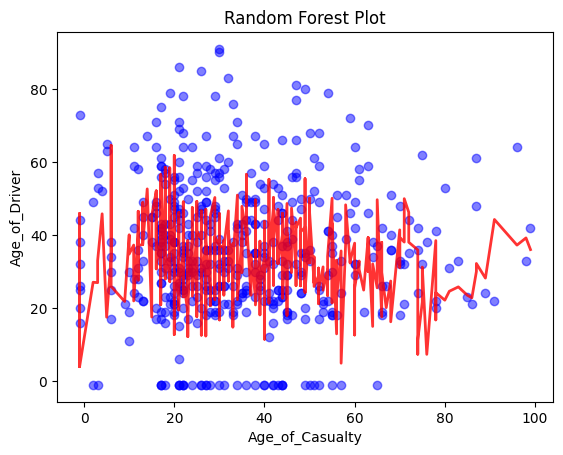

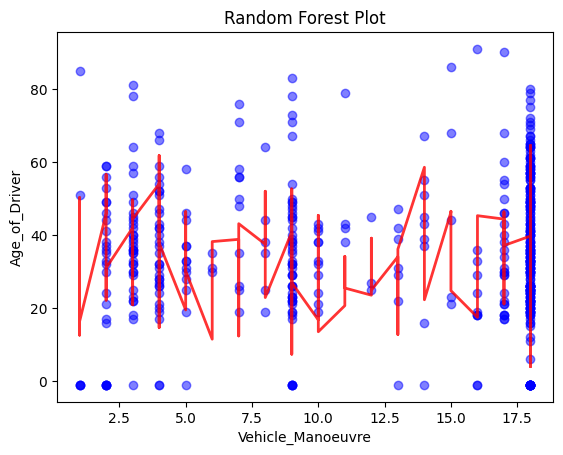

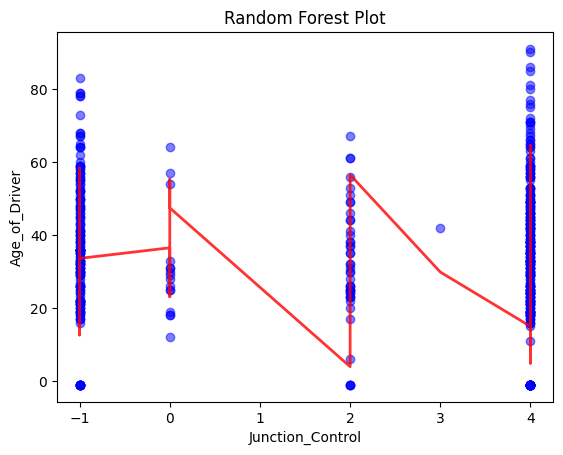

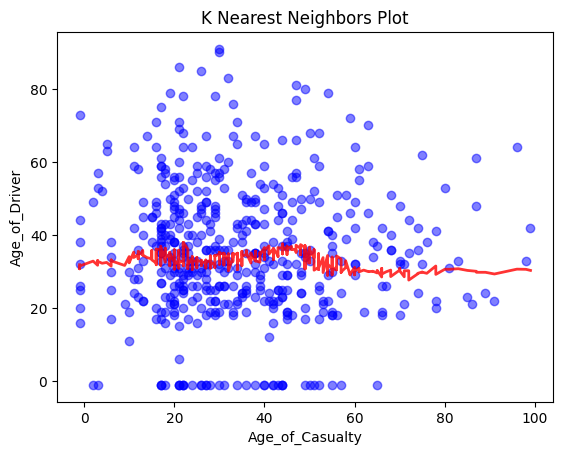

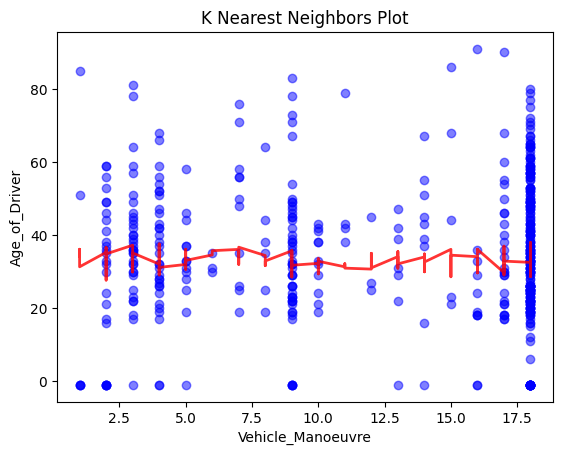

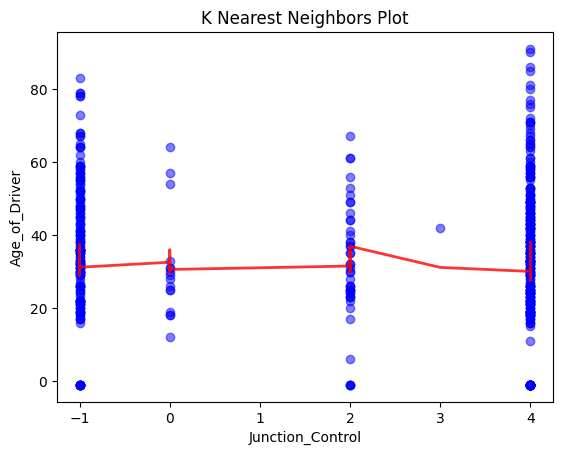

In [97]:
run_regression_models(3, "combination", ["Vehicle_Manoeuvre", "Carriageway_Hazards", "Junction_Control", "Age_of_Casualty", "Accident_Severity", "Casualty_Severity", "Pedestrian_Location", "Pedestrian_Movement", "Age_of_Driver"], 0.001)

**Discussion of the Results**

According to the Random Forest Regressor, the `Vehicle_Manoeuvre`, `Junction_Control`, and `Age_of_Casualty` features contributed the most to the regression models determination of the driver's age in an accident.  Unfortunately, the K Nearest Neighbors Regressor is unable to provide us with a list of values implying the importance of each feature in its determination of a regression line.  Upon running our models on these three features, we noticed that our models found the `Vehicle_Manoeuvre` feature proved to be most useful in determining the beforementioned age of the driver.

We did struggle to make the generated graphs readable.  But before long, we learned that the entries needed to be in ascending order according to our chosen label, which in this case was the `Age_of_Driver`.  After ordering our data, the graphs became readable.  However, the scatterplot and determined regression lines from both the Random Forest and K Nearest Neigbors regressors showed that despite our initial thoughts, the state of the vehicles, the presence of pedestrians, and the severity of the accident did not hint at an approximate age of a driver involved in a car accident in the United Kingdom.

### Works Cited

- Płoński, Piotr. “Random Forest Feature Importance Computed in 3 Ways with Python.” MLJAR, Piotr Płoński, 29 June 2020, mljar.com/blog/feature-importance-in-random-forest/. 
- Sahai, Nidhi. “Mastering Random Forest Regression: A Comprehensive Guide.” Blogs &amp; Updates on Data Science, Business Analytics, AI Machine Learning, 6 Sept. 2023, www.analytixlabs.co.in/blog/random-forest-regression/#:~:text=You%20can%20evaluate%20the%20model,forest%20model%20for%20regression%20problems. 
- Sai, Nikhil. “Cross-Validation with Linear Regression.” Kaggle, Kaggle, 20 Aug. 2019, www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression. 
- Save, Soham. “Accident Data Analysis.” Kaggle, Kaggle, 2 Sept. 2018, www.kaggle.com/code/sohamsave/accident-data-analysis. 